In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import nutpie

print(f"Running on PyMC v{pm.__version__}")

# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Running on PyMC v5.20.1


In [2]:
# set the genuine model constants
sigma_true = 1
alpha_true = np.array([1, 1.5, 2.5])

# number of fake data points
N = 277
X = np.empty((N, 3))
X[:, 0] = np.ones(N)
X[:, 1:] = np.random.randn(N, 2)

# simulate epsilon as N(0, sigma_true**2)
epsilon = rng.normal(size=N) * sigma_true
Y = X @ alpha_true + epsilon

basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=1.5, sigma=2, shape=3)
    sigma = pm.HalfNormal("sigma", sigma=2)

    predictors = pm.Data("predictors", X)

    # Expected value of outcome
    # mu = predictors @ alpha
    mu = pm.Deterministic("mu", predictors @ alpha)

    # Likelihood (sampling distribution) of observations
    # mu.shape is vital for out of sample predictive.
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, shape=mu.shape, observed=Y)


In [3]:
compiled_model = nutpie.compile_pymc_model(basic_model)

/home/jake/miniforge3/envs/pymc_env/lib/python3.12/site-packages/pymc/pytensorf.py:1057: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/home/jake/miniforge3/envs/pymc_env/lib/python3.12/site-packages/pymc/pytensorf.py:1057: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


In [4]:
trace_pymc = nutpie.sample(compiled_model,draws=2749, chains=5)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3049,0,1.01,3
,3049,0,0.98,3
,3049,0,1.00,3
,3049,0,1.04,3
,3049,0,0.95,3


In [5]:
trace_pymc

Inference data with groups:
	> posterior
	> sample_stats

Warmup iterations saved (warmup_*).

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.09,0.06,0.98,1.21,0.0,0.0,22179.91,11335.96,1.0
alpha[1],1.55,0.06,1.44,1.67,0.0,0.0,21231.52,11428.98,1.0
alpha[2],2.47,0.06,2.35,2.58,0.0,0.0,22828.13,11326.85,1.0
sigma_log__,0.02,0.04,-0.06,0.10,0.0,0.0,22465.03,10686.24,1.0
sigma,1.02,0.04,0.94,1.11,0.0,0.0,22465.03,10686.24,1.0
...,...,...,...,...,...,...,...,...,...
mu[272],2.43,0.09,2.26,2.59,0.0,0.0,21195.34,11120.97,1.0
mu[273],0.35,0.07,0.22,0.48,0.0,0.0,22304.69,11591.47,1.0
mu[274],0.57,0.10,0.37,0.75,0.0,0.0,20275.77,11329.12,1.0
mu[275],-1.66,0.09,-1.82,-1.50,0.0,0.0,23172.64,11397.80,1.0


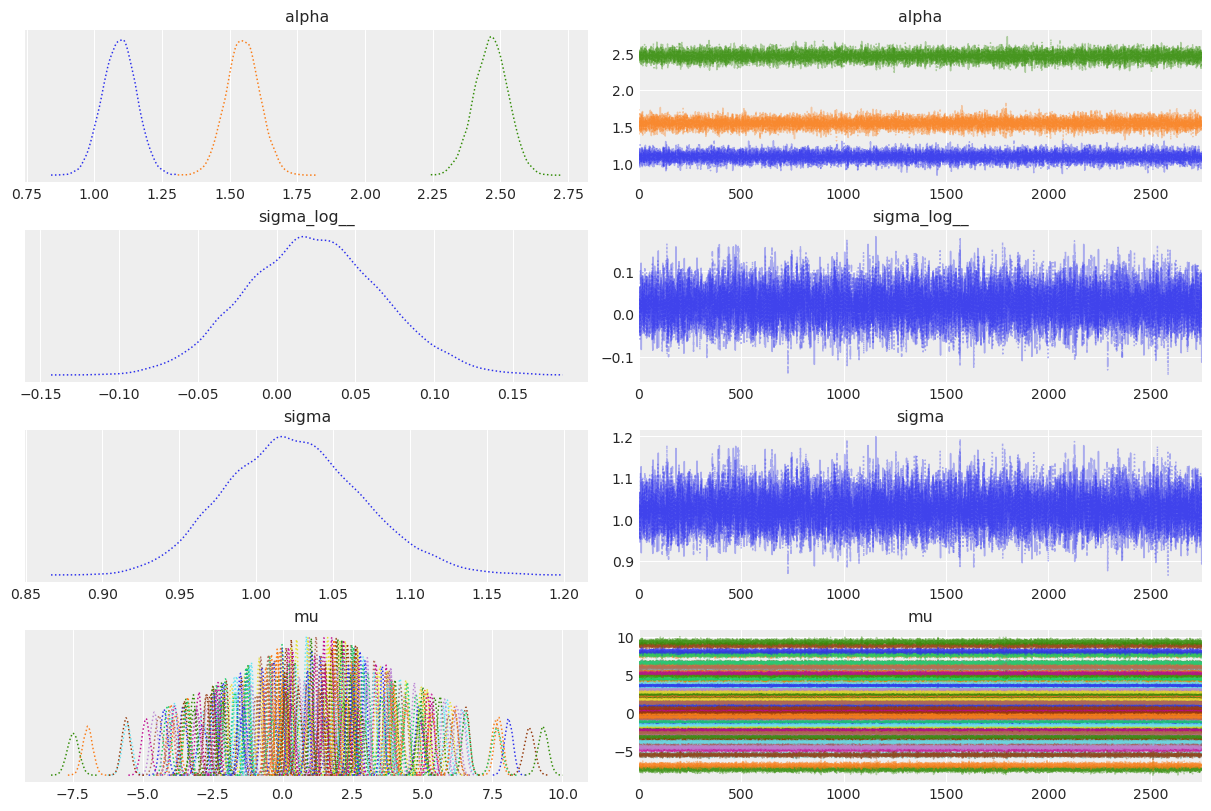

In [6]:
az.plot_trace(trace_pymc, combined=True)
az.summary(trace_pymc, round_to=2)


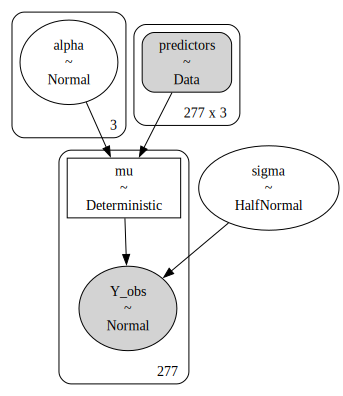

In [7]:
pm.model_to_graphviz(basic_model)

## Posterior Predictive

In [8]:
with basic_model:
    # posterior_predictive_idata = pm.sample_posterior_predictive(trace_pymc)
    posterior_predictive_idata = pm.sample_posterior_predictive(trace_pymc, var_names=["Y_obs", "mu"])

Sampling: [Y_obs]


Output()

In [9]:
posterior_predictive_idata

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [10]:
# This gives a plot with a line for each simulated y
# each simulated y is a single draw from a single chain
# hence n_chains * n_draws lines in total
# az.plot_ppc(posterior_predictive_idata)

# good to know
# all(posterior_predictive_idata['observed_data']['Y_obs'] == Y)
# Gives True

Text(0.5, 0, 'Predictor (X1)')

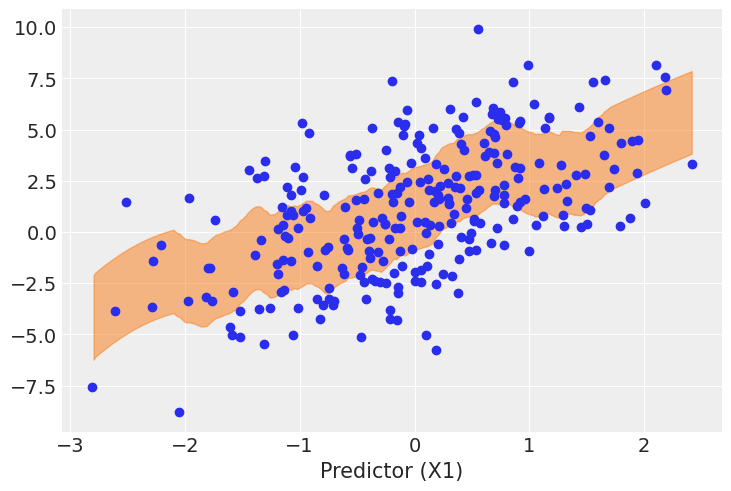

In [11]:
fig, ax = plt.subplots()

az.plot_hdi(X[:,1], posterior_predictive_idata['posterior_predictive']['Y_obs'],hdi_prob=0.95)
ax.scatter(X[:,1], posterior_predictive_idata.observed_data["Y_obs"])

ax.set_xlabel("Predictor (X1)")

In [12]:
posterior_predictive_idata["posterior_predictive"]

<xarray.Dataset> Size: 61MB
Dimensions:      (chain: 5, draw: 2749, Y_obs_dim_2: 277, mu_dim_2: 277)
Coordinates:
  * chain        (chain) int64 40B 0 1 2 3 4
  * draw         (draw) int64 22kB 0 1 2 3 4 5 ... 2743 2744 2745 2746 2747 2748
  * Y_obs_dim_2  (Y_obs_dim_2) int64 2kB 0 1 2 3 4 5 ... 271 272 273 274 275 276
  * mu_dim_2     (mu_dim_2) int64 2kB 0 1 2 3 4 5 6 ... 271 272 273 274 275 276
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 30MB -3.358 -1.93 ... 4.415
    mu           (chain, draw, mu_dim_2) float64 30MB -3.83 -0.9071 ... 2.747
Attributes:
    created_at:                 2025-03-01T14:32:27.729536+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.1

Text(0.5, 0, 'Predictor (X1)')

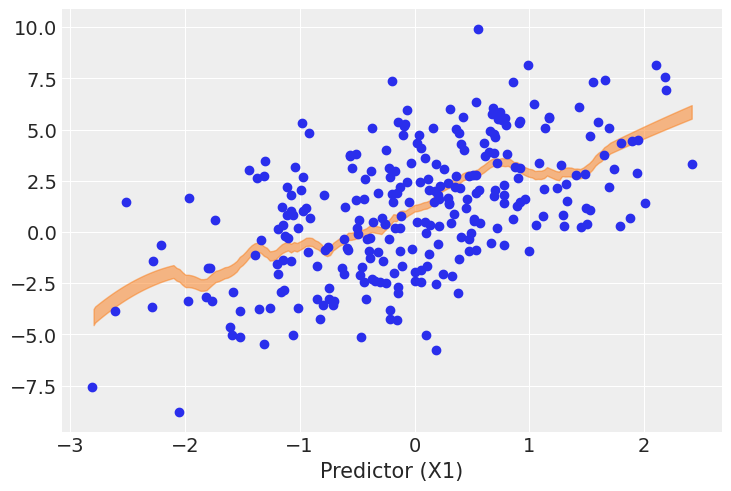

In [13]:
# not really practical but shwoing that we can plot mu
fig, ax = plt.subplots()

az.plot_hdi(X[:,1], posterior_predictive_idata['posterior_predictive']['mu'],hdi_prob=0.95)
ax.scatter(X[:,1], posterior_predictive_idata.observed_data["Y_obs"])

ax.set_xlabel("Predictor (X1)")

This agrees with the actual mean of the data

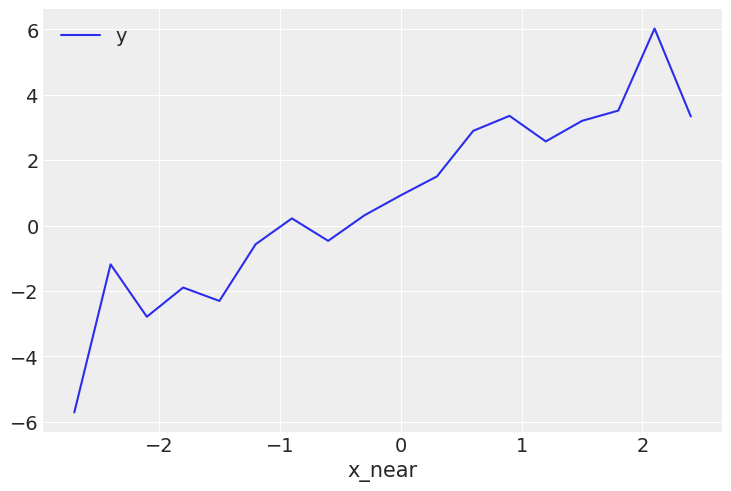

In [14]:
delta = 3e-1
mean_plot_df = pd.DataFrame(data = np.stack([X[:,1],Y], axis=1),columns=['x','y'])
mean_plot_df['x_near'] = np.round(X[:,1]/delta)*delta
mean_plot_df = mean_plot_df.groupby("x_near").agg({"y":"mean"}).reset_index()
mean_plot_df.plot(x="x_near",y="y")
pass

Predict on new X data

In [15]:
N_out_of_sample = 100
X_out_of_sample = np.empty((N_out_of_sample, 3))
X_out_of_sample[:, 0] = np.ones(N_out_of_sample)
X_out_of_sample[:, 1] = np.random.randn(N_out_of_sample) + 6
X_out_of_sample[:, 2] = 0

In [16]:
X_out_of_sample.shape

(100, 3)

In [30]:
X_out_of_sample.dtype

dtype('float64')

In [26]:
with basic_model:
    pm.set_data({"predictors": X_out_of_sample})
    out_sample_idata = pm.sample_posterior_predictive(trace_pymc, predictions=True, return_inferencedata=True, var_names=['Y_obs'])

Sampling: [Y_obs]


Output()

In [31]:
basic_model.coords

{}

In [21]:
out_sample_idata

Inference data with groups:
	> predictions
	> predictions_constant_data

Text(0.5, 0, 'Predictor (X1)')

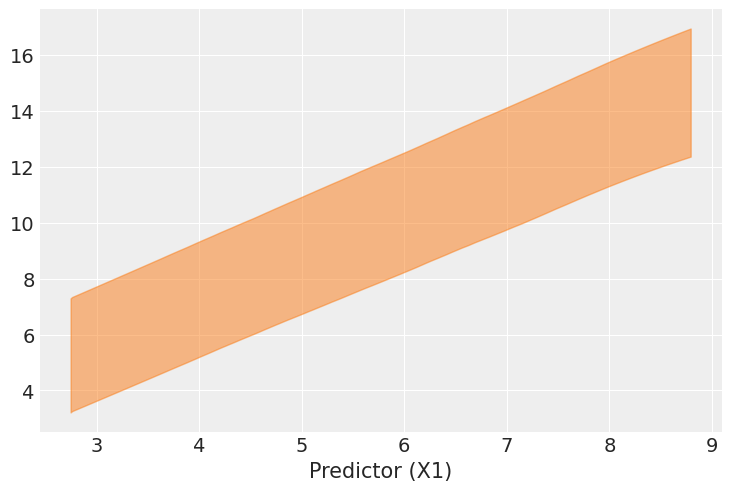

In [19]:
fig, ax = plt.subplots()

az.plot_hdi(X_out_of_sample[:,1], out_sample_idata['predictions']['Y_obs'],hdi_prob=0.95)

ax.set_xlabel("Predictor (X1)")

### TODO

Read the pymc docs on [posterior predictive](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html#prediction).

Another guide on [posterior prediction](https://www.pymc-labs.com/blog-posts/out-of-model-predictions-with-pymc/)
that was mentioned in
[this forum](https://discourse.pymc.io/t/model-compilation-avoidance-when-reusing-a-model/13863).